In [9]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.externals import joblib

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

In [153]:
import re
# 格式为[ type, ...]
def get_lin_type(type_list):
    return_list = []
    for i in range(len(type_list)-1):
        if type_list[i] == 'para' and type_list[i+1] == 'para':
            return_list.append(1)
        else:
            return_list.append(0)
    return_list.append(0)
    return return_list

# 格式为[text, ...]
def next_is_shiyong(text):
    return_list = []
    for i in range(len(text)-1):
        if re.search('^□.*√.*', str(text[i+1])):
            return_list.append(1)
        else:
            return_list.append(0)
    return_list.append(0)
    return return_list


In [ ]:
file1 = pd.read_csv('model5_return已标注段落.csv',encoding='gbk')
file1['is_continue'] = get_lin_type(file1['type'].values)
file1['is_next_shiyong'] = next_is_shiyong(file1['text'].values)
file1 = file1.loc[file1['type']=='para']
para_max = file1['x1'].max()
file1['para_max'] = para_max - file1['x1']
for i in ['x0','x1','top','size','height','width','adv']:
    new_data = file1[i].tolist()[1:]
    new_data.append(0)
    file1[i+'_next'] = new_data
    
file2 = pd.read_csv('model6_return段落已标注.csv',encoding='gbk')
file2['is_continue'] = get_lin_type(file2['type'].values)
file2['is_next_shiyong'] = next_is_shiyong(file2['text'].values)
file2 = file2.loc[file2['type']=='para']
para_max = file2['x1'].max()
file2['para_max'] = para_max - file2['x1']
for i in ['x0','x1','top','size','height','width','adv']:
    new_data = file2[i].tolist()[1:]
    new_data.append(0)
    file2[i+'_next'] = new_data


In [214]:

file3 = pd.read_csv('model8_return修正.csv',encoding='gbk')   
file3['is_continue'] = get_lin_type(file3['type'].values)
file3['is_next_shiyong'] = next_is_shiyong(file3['text'].values)
file3 = file3.loc[file3['type'] == 'para']
para_max = file3['x1'].max()
file3['para_max'] = para_max - file3['x1']
file3['continue'] = file3.apply(lambda x:x['is_para'] if str(x['xiuzheng']) == 'nan' else x['xiuzheng'], axis=1)
file3.drop(['xiuzheng','is_para'], inplace=True, axis=1)
file3 = file3.loc[file3['type']=='para']
for i in ['x0','x1','top','size','height','width','adv']:
    new_data = file3[i].tolist()[1:]
    new_data.append(0)
    file3[i+'_next'] = new_data
    
#file = pd.concat([file1,file2,file3])
file = file3

In [215]:
file.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 385 entries, 0 to 2606
Data columns (total 32 columns):
Unnamed: 0            385 non-null int64
adv                   385 non-null float64
bottom                385 non-null float64
cod                   385 non-null int64
doctop                385 non-null float64
fontname              385 non-null object
height                385 non-null float64
non_stroking_color    385 non-null float64
object_type           385 non-null object
page_number           385 non-null float64
size                  385 non-null float64
stroking_color        385 non-null float64
text                  385 non-null object
top                   385 non-null float64
type                  385 non-null object
upright               385 non-null object
width                 385 non-null float64
x0                    385 non-null float64
x1                    385 non-null float64
y0                    385 non-null float64
y1                    385 non-null float64


In [216]:
para_data = file.loc[file['type']=='para']
#file_next_value = para_data[['x0','x1','y0','y1','top','bottom','doctop','size','height','width','adv']]
#file_next_value.rename(columns = {
#    'x0':'x2','x1':'x3','y0':'y2','y1':'y3','top':'top1','bottom':'bottom1','size':'size1',
#    'height':'height1','width':'width1','adv':'adv1'
#}, inplace=True)


In [217]:
para_data['len_str'] = para_data['text'].apply(lambda x:len(x))

In [218]:
ling_str=['、',',',':',')','!','。',';']
para_data['end_str'] = para_data['text'].apply(lambda x:ling_str.index(str(x).strip()[-1]) if str(x).strip()[-1] in ling_str else 0)

In [219]:
para_data.head()

,Unnamed: 0,adv,bottom,cod,doctop,fontname,height,non_stroking_color,object_type,page_number,...,continue,x0_next,x1_next,top_next,size_next,height_next,width_next,adv_next,len_str,end_str
0,0,15.96,173.510,0,157.550,ABCDEE+黑体,15.96,0.0,char,1.0,...,0.0,241.49,255.53,189.800,14.04,14.04,14.04,14.04,15,0
1,1,14.04,203.840,1,189.800,ABCDEE+黑体,14.04,0.0,char,1.0,...,0.0,260.69,320.57,221.000,14.04,14.04,14.04,14.04,8,0
2,2,14.04,235.040,2,221.000,ABCDEE+宋体,14.04,0.0,char,1.0,...,0.0,255.65,267.65,463.762,12.00,12.00,12.00,12.00,7,0
3,3,12.00,475.762,3,463.762,ABCDEE+宋体,12.00,0.0,char,1.0,...,0.0,273.53,285.53,84.872,12.00,12.00,12.00,12.00,7,0
4,4,12.00,96.872,0,926.792,ABCDEE+宋体,12.00,0.0,char,2.0,...,0.0,111.02,121.58,127.989,10.56,10.56,10.56,10.56,4,0


In [220]:
para_data.columns

Index(['Unnamed: 0', 'adv', 'bottom', 'cod', 'doctop', 'fontname', 'height',
       'non_stroking_color', 'object_type', 'page_number', 'size',
       'stroking_color', 'text', 'top', 'type', 'upright', 'width', 'x0', 'x1',
       'y0', 'y1', 'is_continue', 'is_next_shiyong', 'para_max', 'continue',
       'x0_next', 'x1_next', 'top_next', 'size_next', 'height_next',
       'width_next', 'adv_next', 'len_str', 'end_str'],
      dtype='object')

In [221]:
para_data.drop(['Unnamed: 0','fontname','text','object_type','upright','type','cod','page_number','y0','y1','bottom','doctop'],axis=1,inplace=True)

In [222]:
para_data.drop(['non_stroking_color','stroking_color'],axis=1,inplace=True)

In [16]:
# 归一化处理
clf = MinMaxScaler().fit_transform(para_data[['bottom', 'doctop', 'height', 'size',
       'top', 'width', 'x0', 'x1', 'y0', 'y1', 'x0_next', 'x1_next', 'y0_next',
       'y1_next', 'top_next', 'bottom_next', 'doctop_next', 'size_next',
       'height_next', 'width_next', 'adv_next']])

para_data[['bottom', 'doctop', 'height', 'size',
       'top', 'width', 'x0', 'x1', 'y0', 'y1', 'x0_next', 'x1_next', 'y0_next',
       'y1_next', 'top_next', 'bottom_next', 'doctop_next', 'size_next',
       'height_next', 'width_next', 'adv_next']] = clf


/home/sunday/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
/home/sunday/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [223]:
para_data.head()

,adv,height,size,top,width,x0,x1,is_continue,is_next_shiyong,para_max,continue,x0_next,x1_next,top_next,size_next,height_next,width_next,adv_next,len_str,end_str
0,15.96,15.96,15.96,157.550,15.96,177.14,193.10,1,0,312.514,0.0,241.49,255.53,189.800,14.04,14.04,14.04,14.04,15,0
1,14.04,14.04,14.04,189.800,14.04,241.49,255.53,1,0,250.084,0.0,260.69,320.57,221.000,14.04,14.04,14.04,14.04,8,0
2,14.04,14.04,14.04,221.000,14.04,260.69,320.57,1,0,185.044,0.0,255.65,267.65,463.762,12.00,12.00,12.00,12.00,7,0
3,12.00,12.00,12.00,463.762,12.00,255.65,267.65,1,0,237.964,0.0,273.53,285.53,84.872,12.00,12.00,12.00,12.00,7,0
4,12.00,12.00,12.00,84.872,12.00,273.53,285.53,1,0,220.084,0.0,111.02,121.58,127.989,10.56,10.56,10.56,10.56,4,0


In [224]:
y_file = para_data['continue']
x_file = para_data.drop('continue', axis=1)

0.9607925739504688


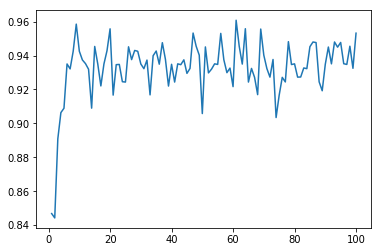

In [225]:
score_list = []

for i in range(100):
    clf = RandomForestClassifier(max_depth=1+i,criterion='entropy')
    score = cross_val_score(clf,x_file, y_file, cv =10)
    score_list.append(score.mean())
    
print(max(score_list))
plt.plot(range(1,101),score_list)
plt.show()

0.9579476237370974


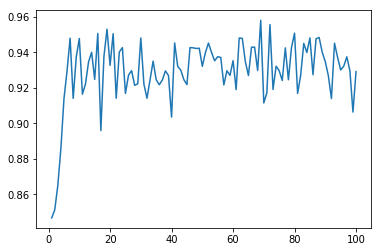

In [226]:
score_list = []

for i in range(100):
    clf = RandomForestClassifier(max_depth=1+i,criterion='gini')
    score = cross_val_score(clf,x_file, y_file, cv =10)
    score_list.append(score.mean())
    
print(max(score_list))
plt.plot(range(1,101),score_list)
plt.show()

In [227]:
parameters = {
    'n_estimators':[*range(1,20)],
    'criterion':['gini','entropy'],
    'max_depth':[*range(1,10)],
    #'max_features':['auto','sqrt','log2',None],
    #'min_samples_split':[*np.linspace(0.00000001,1,50)]
}


rfc = RandomForestClassifier()
gs = GridSearchCV(rfc, parameters, cv=10)

In [228]:
gs.fit(x_file,y_file)

GridSearchCV(cv=10, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_estimators': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19], 'criterion': ['gini', 'entropy'], 'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [229]:
x_file.columns

Index(['adv', 'height', 'size', 'top', 'width', 'x0', 'x1', 'is_continue',
       'is_next_shiyong', 'para_max', 'x0_next', 'x1_next', 'top_next',
       'size_next', 'height_next', 'width_next', 'adv_next', 'len_str',
       'end_str'],
      dtype='object')

In [230]:
gs.best_score_

0.9584415584415584

In [205]:
gs.best_params_

{'max_depth': 3, 'max_features': 16, 'n_estimators': 18}

In [211]:
clf = RandomForestClassifier(max_depth=3,max_features=16,n_estimators=18,criterion='entropy')
score = cross_val_score(clf,x_file,y_file,cv=10)
print(score)
print(score.mean())

[1.         0.97142857 0.92857143 1.         0.98550725 0.92753623
 0.88405797 0.97101449 0.91176471 0.89705882]
0.947693947144075


In [213]:
x_file

,adv,adv_next,height,height_next,is_continue,is_next_shiyong,para_max,size,size_next,top,top_next,width,width_next,x0,x0_next,x1,x1_next,len_str,end_str
0,1.000,1.000,19.98,19.98,1,0,348.360,19.98,19.98,187.297,218.497,19.980,19.980,136.980,257.460,156.960,277.440,16,0
1,1.000,1.000,19.98,19.98,1,0,227.880,19.98,19.98,218.497,249.697,19.980,19.980,257.460,219.720,277.440,239.700,4,0
2,1.000,0.250,19.98,19.98,1,0,265.620,19.98,19.98,249.697,252.973,19.980,4.995,219.720,174.723,239.700,425.535,10,0
3,0.250,1.000,19.98,16.02,1,0,79.785,19.98,16.02,252.973,391.967,4.995,16.020,174.723,169.140,425.535,185.160,4,0
4,1.000,1.000,16.02,12.00,1,0,320.160,16.02,12.00,391.967,421.188,16.020,12.000,169.140,192.660,185.160,204.660,16,0
5,1.000,1.000,12.00,16.02,1,0,300.660,12.00,16.02,421.188,563.567,12.000,16.020,192.660,241.620,204.660,257.640,19,0
6,1.000,1.000,16.02,12.00,1,0,247.680,16.02,12.00,563.567,639.588,16.020,12.000,241.620,216.660,257.640,228.660,7,0
7,1.000,1.000,12.00,13.98,1,0,276.660,12.00,13.98,639.588,665.953,12.000,13.980,216.660,248.640,228.660,262.620,15,0
8,1.000,1.000,13.98,18.00,1,0,242.700,13.98,18.00,665.953,79.032,13.980,18.000,248.640,261.540,262.620,279.540,7,0
9,1.000,1.000,18.00,12.00,1,0,225.780,18.00,12.00,79.032,140.388,18.000,12.000,261.540,114.000,279.540,126.000,4,0


In [150]:
joblib.dump(gs.best_estimator_, 'para.pkl')

['para.pkl']

In [144]:
from sklearn import svm

0.9420289855072463


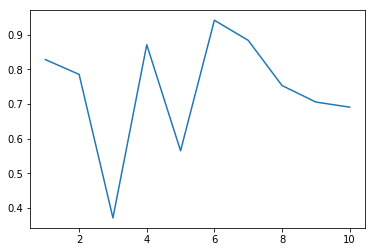

In [147]:
clf = svm.LinearSVC()
score = cross_val_score(clf,x_file, y_file, cv =10)
score
    
print(max(score))
plt.plot(range(1,11),score)
plt.show()

In [149]:
gs.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=3, max_features=14, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=14, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [141]:
gs.best_params_

{'max_depth': 3, 'max_features': 14, 'n_estimators': 14}

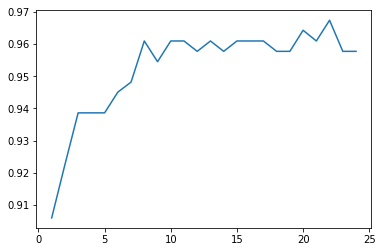

In [142]:
score_list = []

for i in range(1,25):
    rfc = RandomForestClassifier(max_depth=6, max_features=i, n_estimators=94)
    rfc = cross_val_score(rfc,x_file,y_file,cv=10)
    score_list.append(rfc.mean())

plt.plot(range(1,25),score_list)
plt.show()


In [143]:
max(score_list)

0.9674193548387097

In [144]:
len(score_list)

24

In [148]:
x_file.columns

Index(['adv', 'bottom', 'cod', 'doctop', 'height', 'page_number', 'size',
       'top', 'width', 'x0', 'x1', 'y0', 'y1', 'x0_next', 'x1_next', 'y0_next',
       'y1_next', 'top_next', 'bottom_next', 'doctop_next', 'size_next',
       'height_next', 'width_next', 'adv_next', 'len_str', 'is_mulu'],
      dtype='object')

In [249]:
x = '第一节,第二季，第五'

In [257]:
y = re.('((?!，,).{0,2}[一二三四五六七八九十]{1,2})',x)

In [259]:
t = [1,2,1,1,1,1,1]

In [261]:
t.index(1)

0

<class 'pandas.core.frame.DataFrame'>
Int64Index: 385 entries, 0 to 2606
Data columns (total 19 columns):
adv                385 non-null float64
height             385 non-null float64
size               385 non-null float64
top                385 non-null float64
width              385 non-null float64
x0                 385 non-null float64
x1                 385 non-null float64
is_continue        385 non-null int64
is_next_shiyong    385 non-null int64
para_max           385 non-null float64
x0_next            385 non-null float64
x1_next            385 non-null float64
top_next           385 non-null float64
size_next          385 non-null float64
height_next        385 non-null float64
width_next         385 non-null float64
adv_next           385 non-null float64
len_str            385 non-null int64
end_str            385 non-null int64
dtypes: float64(15), int64(4)
memory usage: 60.2 KB


In [264]:
print()

ä¸ãæä¿å½çä¸»è¦åå®¹


In [275]:
x = '\xe4\xb8\x80\xe3\x80\x81\xe6\x8b\x85\xe4\xbf\x9d\xe5\x87\xbd\xe7\x9a\x84\xe4\xb8\xbb\xe8\xa6\x81\xe5\x86\x85\xe5\xae\xb9'

In [276]:
x.decode('gbk')

AttributeError: 'str' object has no attribute 'decode'

In [277]:
clf = RandomForestClassifier()